In [411]:
# Imports

import glob
import numpy as np
from nilearn import image, plotting
from nilearn.image import new_img_like
from scipy import ndimage
import os
import scipy.io
import warnings
warnings.filterwarnings("ignore")

In [2]:
main_folder = 'C:\\Users\\davide\\Documents\\GitHub\\wp1_2_roast\\' #main folder with data
bck_img_map = image.load_img(os.path.join(main_folder, 'rois' ,'MNI152_T1_1mm_Brain.nii')) #Background for plotting purposes
bck_img_map_smoothed = image.smooth_img(bck_img_map, fwhm=2) # MNI template smoothed (plotting purpo)
#List of subjects
subjects = ['01','02','03','04','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','22','23','24']

#subjects = ['01','02','03', '04']

# .mat file with DCM results for Day-1 only. It contains all the EP values for anodal, cathodal and sham.
# I am interested only in anodal (indexes 0, 3, 6 ... 64)
dcm_data_day1_path = os.path.join(main_folder, 'wp2a_DCMfiles', 'Day1_all_EPvalues.mat') 
dcm_data_day1 = scipy.io.loadmat(dcm_data_day1_path)

# Posterior probability associated to each connection (per participant and for anodal, cathodal and sham, same as above).
# This is no longer used
pp_data_day1_path = os.path.join(main_folder, 'wp2a_DCMfiles','Day1_all_Pp.mat') 
pp_data_day1 = scipy.io.loadmat(pp_data_day1_path)

# Example: How to access DCM / PEB values for the anodal condition for participant 2
# Indexes: participant 1 -> 0, participant 2 -> 3, participant 3 -> 6 ... 64
# index = 3 # index corresponding to participant 2 (anodal)
# dcm_values = np.array(dcm_data_day1['ALLEP'][0][index].todense().reshape((4,4))).T
# pp_values = pp_data_day1['BMAs'][0][index]['Pp'][0][0][16:32].reshape([4,4]).T # PP values no longer used!

#Loading Regions of interest (Rois). These will be used to mask the electric field maps
# https://www.oxcns.org/papers/607%20Rolls%20Huang%20Lin%20Feng%20Joliot%202020%20AAL3.pdf 
AAl3_path = os.path.join(main_folder,'rois','AAL3v1_1mm.nii')
AAL3_atlas = image.load_img(AAl3_path)
# AAL3 index for M1 = 1
m1 = image.math_img("np.where(img == 1, 1, 0)", img=AAL3_atlas) 
# AAL3 index for TH = 121 - 149 (odd values only (left))
th = image.math_img("np.where(np.isin(img, np.arange(121, 150, 2)), 1, 0)", img=AAL3_atlas) 

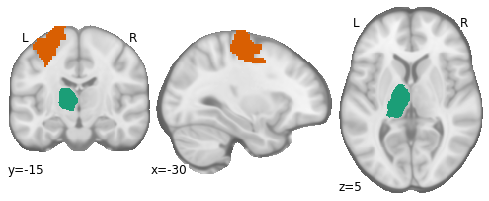

In [3]:
#AAL3 Left M1 and left thalamus ROIs
m1_th = image.math_img('img + np.where(img2 ==1, 2,0)', img = m1, img2 = th)
plotting.plot_stat_map(m1_th,
                       bg_img = bck_img_map,
                       cmap = 'Dark2_r',
                       colorbar = False,
                       cut_coords = [-30,-15,5],
                       draw_cross = False,
                       black_bg = False)

In [4]:
pos_dcm_res = 0 #Position of the DCM results for subject 1, day 1 (anodal) (0, 3, 6 ... 64) 

th_wm = 0.5 # threshold for the white matter
th_gm = 0 # threshold for the grey matter
th_csf = 0.5 # threshold for the csc

# Where I'll save m1 self connections and all th->m1
all_m1selfcon = []
all_thm1 = []
all_thselfcon = []
all_m1th = []

# Where I'll save emag values for m1 and th for each subject (means, medians, max values)
all_m1_emag_means = []
all_th_emag_means = []
all_m1_emag_medians = []
all_th_emag_medians = []
all_m1_emag_max = []
all_th_emag_max = []

# I am also going to store all the Emag maps in a multi-dimentional array, for plotting purposes
all_emag_maps = []

for sbj in subjects:
    path = 'D:\\roast-chapter3\wp2a_copy\sub-' + sbj
    print('Analysing subject: ' + sbj + '. Path: ' + path)
    
    #Loading ROAST Electric field magnitude simulation (V/m)
    emag_map = image.load_img(glob.glob(path + '/wsub-*_T1_*_emag.nii'))
    scan_shape = emag_map.get_fdata().shape[0:3]
    emag_data = emag_map.get_fdata().reshape(scan_shape) # needed to drop 4th dimention in the array (that shouldn't be there)
    emag_map = new_img_like(emag_map, emag_data) 
    
    # Loading masks containing gray matter, white matter and csf
    
    grey_matter = image.load_img(glob.glob(path + '/swc1sub*.nii')).get_fdata().reshape(scan_shape) 
    white_matter = image.load_img(glob.glob(path + '/swc2sub*.nii')).get_fdata().reshape(scan_shape)
    csf = image.load_img(glob.glob(path + '/swc3sub*.nii')).get_fdata().reshape(scan_shape)
    
    # Thresholding maps
    gm_th = np.where(grey_matter > th_gm, grey_matter, 0)
    wm_th = np.where(white_matter > th_wm, white_matter, 0)
    csf_th = np.where(csf > th_csf, csf, 0)     
    
    # Disentangling overlapped / unassigned voxels
    gm_c = np.where((gm_th > wm_th) & (gm_th > csf_th), 1, 0)
    wm_c = np.where((wm_th > gm_th) & (wm_th > csf_th), 2, 0)
    csf_c = np.where((csf_th > wm_th) & (csf_th > gm_th), 3, 0)
    
    # Final mask containing gm wm and csf (idx = 1, 2, 3 respectively)
    wm_gm_csf = new_img_like(emag_map, gm_c + wm_c + csf_c) 
    
    #Exclude values outside the brain using the MNI template
    wm_gm_csf_m = image.math_img("np.where(img2 != 0, img, 0)", img = wm_gm_csf, img2 = mni_resampled)
    
    # Current densities: GM (default 0.276 S/m) and WM (default 0.126 S/m) CSF (default 1.65 S/m)
    # working on this
    cd_gm = np.where(wm_gm_csf_m == 2, 0.126*wm_gm_csf_m, 0)
    
    # Calculating current density
    
    #current_density = 
    # ----------------
    
    
    # Applying fwhm smoothing to the electric field magnitude map. Kernel 4x4x4
    emag_map_smoothed = image.smooth_img(emag_map, fwhm=4) # Emag map
    
    # Resampling MNI anatomical file to emag map (so that they have the same shape)
    mni_resampled = image.resample_to_img(bck_img_map, emag_map, interpolation = 'nearest')    
    
    #Emag map masked (to exclude the skull, and keep only values of voxels in the brain)
    emag_map_masked = image.math_img("np.where(img2 != 0, img, 0)", img=emag_map_smoothed, img2 = mni_resampled)
    
    # Resampling ROIs to the dimention of the emag map
    m1_resampled = image.resample_to_img(m1, emag_map_masked, interpolation = 'nearest')
    th_resampled = image.resample_to_img(th, emag_map_masked, interpolation = 'nearest')
    
    #Loading DCM results and Posterior probabilities for the subject
    #Transposing is needed because the PEB lists values column by row and not row by column...

    this_dcm = np.array(dcm_data_day1['ALLEP'][0][pos_dcm_res].todense().reshape((4,4))).T
    this_pp = pp_data_day1['BMAs'][0][pos_dcm_res]['Pp'][0][0][16:32].reshape([4,4]).T
    
    print('DCM matrix')
    # If you want to see the connectivity matrix for each subject, but thresholded using a posterior probability > 75%
    print(this_dcm)
    #print(np.where(this_pp>0.75,this_dcm,0)) 
    #print('Posterior probability')
    #print(this_pp)
    
    # DCM connectivities I'm interested in 
    m1m1 = this_dcm[0][0]
    thm1 = this_dcm[0][1]
    thth = this_dcm[1][1]
    m1th = this_dcm[1][0]
    
    # Saving the DCM values into separate lists
    all_m1selfcon.append(m1m1)
    all_thm1.append(thm1)
    all_m1th.append(m1th)
    all_thselfcon.append(thth) 
    
    #print('M1<->M1 connectivity: ' + str(m1m1))
    #print('Th<->Th connectivity: ' + str(thth))
    #print('M1<->th connectivity: ' + str(m1th))
    #print('Th<->M1 connectivity: ' + str(thm1))
    
    # Masking emag maps with M1 and Th rois
    emag_masked_m1 = image.math_img("img * img2", img=emag_map_masked, img2 = m1_resampled) #Applying m1 mask
    emag_masked_th = image.math_img("img * img2", img=emag_map_masked, img2 = th_resampled) #Applying th mask
    
    # Assigning nans to zeros to exclude non M1/Th voxels from the calculation of the mean
    emag_masked_m1_nans = np.where(m1_resampled.get_fdata() == 0, np.nan, emag_masked_m1.get_fdata())
    emag_masked_th_nans = np.where(th_resampled.get_fdata() == 0, np.nan, emag_masked_th.get_fdata())

    # Calculating means, medians and max values
    m1_emag_mean = np.nanmean(emag_masked_m1_nans)
    th_emag_mean = np.nanmean(emag_masked_th_nans)
    m1_emag_median = np.nanmedian(emag_masked_m1_nans)
    th_emag_median = np.nanmedian(emag_masked_th_nans)
    m1_emag_max = np.nanmax(emag_masked_m1_nans)
    th_emag_max = np.nanmax(emag_masked_th_nans)
       
    # Saving means, medians and max values into lists
    all_m1_emag_means.append(m1_emag_mean)
    all_th_emag_means.append(th_emag_mean)   
    all_m1_emag_medians.append(m1_emag_median)
    all_th_emag_medians.append(th_emag_median)  
    all_m1_emag_max.append(m1_emag_max)
    all_th_emag_max.append(th_emag_max)   
    
    print('Mean Electric field in M1: ' + str(round(m1_emag_mean,3)))
    print('Mean Electric field in Th: ' + str(round(th_emag_mean,3)))
    print('Median Electric field in M1: ' + str(round(m1_emag_median,3)))
    print('Median Electric field in Th: ' + str(round(th_emag_median,3)))
    print('Max Electric field in M1: ' + str(round(m1_emag_max,3)))
    print('Max Electric field in Th: ' + str(round(th_emag_max,3)))
    print('\n')
    
        
    all_emag_maps.append(emag_map_masked)
    #Moving to the next subject
    pos_dcm_res += 3 
    
    
    
# Saving results into two dictionaries
emag_all_results = {'Medians M1': all_m1_emag_medians,'Medians Th': all_th_emag_medians,
                    'Max values M1': all_m1_emag_max,'Max values Th': all_th_emag_max}

dcm_all_results = {'M1M1': all_m1selfcon, 'M1Th': all_m1th, 'ThTh': all_thselfcon, 'ThM1': all_thm1}

Analysing subject: 01. Path: D:\roast-chapter3\wp2a_copy\sub-01
DCM matrix
[[ 0.05520965 -0.14524401 -0.09662367  0.27560144]
 [-0.07975794  0.02690949  0.00308649  0.16814571]
 [ 0.01390412 -0.1373137   0.1243674   0.07719591]
 [ 0.06479655 -0.15147347 -0.03443308 -0.07778843]]
Mean Electric field in M1: 0.321
Mean Electric field in Th: 0.083
Median Electric field in M1: 0.149
Median Electric field in Th: 0.084
Max Electric field in M1: 3.615
Max Electric field in Th: 0.128


Analysing subject: 02. Path: D:\roast-chapter3\wp2a_copy\sub-02
DCM matrix
[[-0.36221701  0.00203647 -0.07713241  0.00833455]
 [ 0.00997627  0.00878465 -0.13382803  0.18316923]
 [ 0.40141591 -0.10109212  0.0541691  -0.03446576]
 [ 0.04818541 -0.02943239 -0.16035369  0.02870905]]
Mean Electric field in M1: 0.287
Mean Electric field in Th: 0.081
Median Electric field in M1: 0.131
Median Electric field in Th: 0.082
Max Electric field in M1: 3.207
Max Electric field in Th: 0.124


Analysing subject: 03. Path: D:\roas

DCM matrix
[[ 0.24043698 -0.39011649  0.13238153  0.30580157]
 [-0.08149922 -0.00413045 -0.05240137  0.03294866]
 [ 0.07385882 -0.09546929 -0.06943192 -0.11212045]
 [ 0.04851577 -0.06429536  0.02911241 -0.01552057]]
Mean Electric field in M1: 0.327
Mean Electric field in Th: 0.105
Median Electric field in M1: 0.175
Median Electric field in Th: 0.106
Max Electric field in M1: 3.033
Max Electric field in Th: 0.144


Analysing subject: 20. Path: D:\roast-chapter3\wp2a_copy\sub-20
DCM matrix
[[-0.06944493  0.41139099 -0.40751761  0.30989566]
 [ 0.16814856 -0.0353208  -0.10681562 -0.12050632]
 [ 0.44109553 -0.0650278  -0.12199429 -0.04824721]
 [ 0.08222474  0.19752884 -0.1340618  -0.06784703]]
Mean Electric field in M1: 0.256
Mean Electric field in Th: 0.077
Median Electric field in M1: 0.137
Median Electric field in Th: 0.078
Max Electric field in M1: 2.919
Max Electric field in Th: 0.119


Analysing subject: 22. Path: D:\roast-chapter3\wp2a_copy\sub-22
DCM matrix
[[-0.22113984  0.04457101

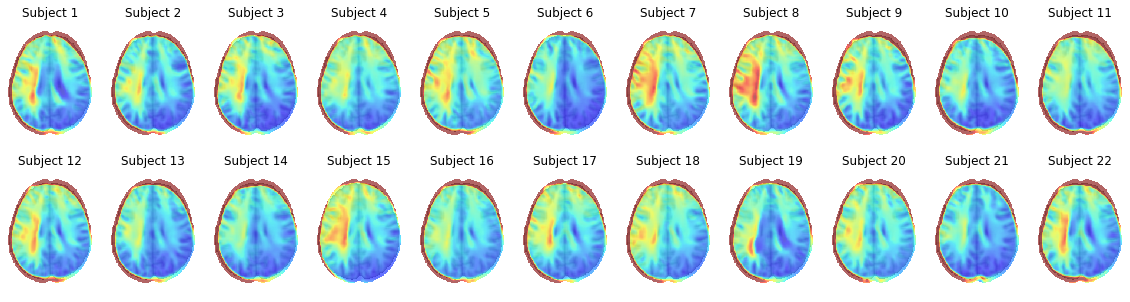

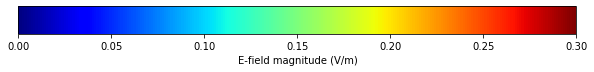

In [5]:
# create a figure with multiple axes to plot each Emag map
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=11, figsize=(20,5))

vmin, vmax = 0, 0.3 # Color map min and max
# axes is a 2 dimensional numpy array
subject = 0
for ax in axes.flatten():
    display = plotting.plot_roi(all_emag_maps[subject],
              #bg_img = bck_img_map_smoothed,
              display_mode = 'z',
              annotate = False,
              dim = 0.5,
              cmap = 'jet',
              cut_coords = [28],
              threshold = 0.001,
              vmin = vmin,
              vmax = vmax,
              alpha = 0.60,
              draw_cross = False,
              black_bg = False,
              axes = ax)
    ax.title.set_text('Subject ' + str(subject + 1))
    subject += 1
    
# Colorbar for the above brain plots
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='E-field magnitude (V/m)')    
    

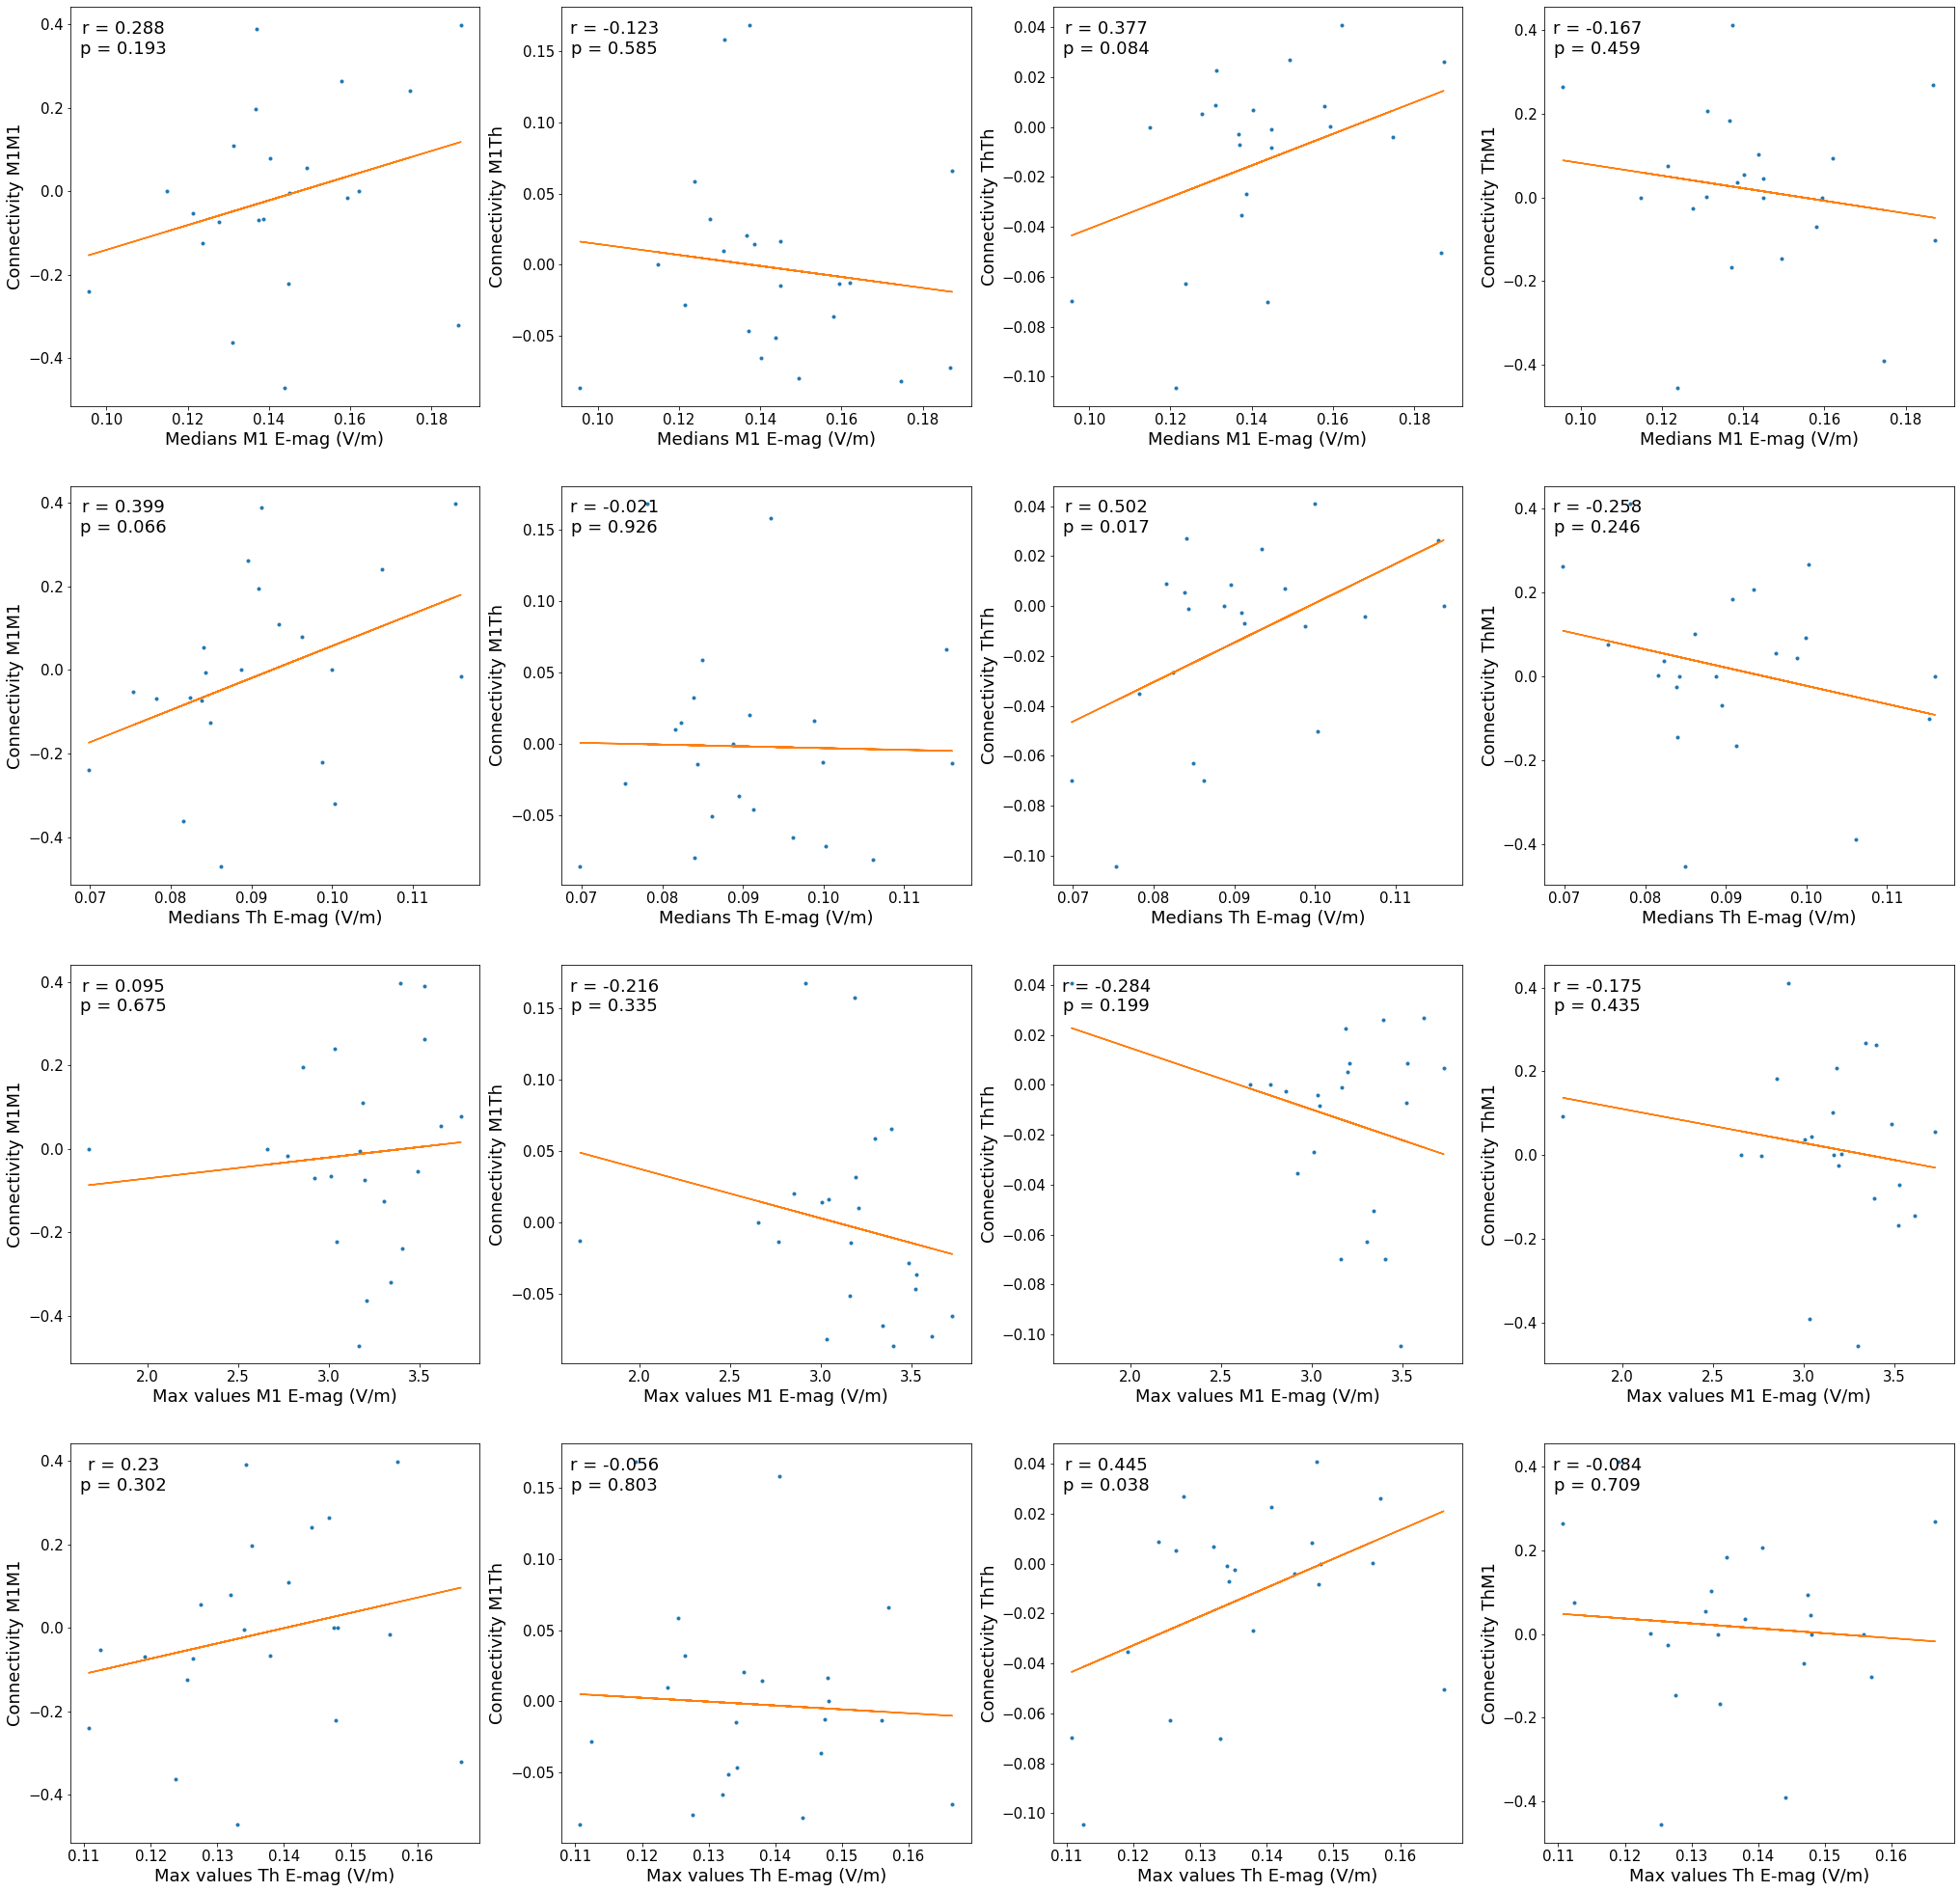

In [6]:
# Correlations between connectivity measures and Electric field magnitude medians and max values
from numpy.polynomial.polynomial import polyfit

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(35,35))

idx = 0
for emag_measure in emag_all_results:
    for dcm_con in dcm_all_results:
        x = np.transpose(emag_all_results[emag_measure])
        y = np.transpose(dcm_all_results[dcm_con])
        r,p  = scipy.stats.pearsonr(x, y)    # Pearson's r

        # Correlation Plot
        row = int(idx/4);
        col = int(idx%4); 
        b, m = polyfit(x, y, 1)
        
        axes[row][col].plot(x, y, '.')
        axes[row][col].plot(x, b + m * x, '-')
        #axes[row][col].title.set_text('Correlating ' + emag_measure + ' with ' + dcm_con)
        axes[row][col].set_xlabel(emag_measure + ' E-mag (V/m)', fontsize = 18)
        axes[row][col].set_ylabel('Connectivity ' + dcm_con, fontsize = 18)
        axes[row][col].tick_params(axis='both', which='major', labelsize=15)
        axes[row][col].text(0.13, 0.92, 'r = ' + str(round(r,3)) + '\np = ' + str(round(p,3)), horizontalalignment='center',
                            verticalalignment='center', transform=axes[row][col].transAxes, fontsize = 18)
        idx += 1
        

In [ ]:
# Plot WM / GM / CSF binary parcellation and derived current densities maps

from ipywidgets import IntProgress
from IPython.display import display
import time

#Progressbar 
f = IntProgress(min=0, max=22) # instantiate the bar
f.description = 'Binarising WM, GM and CSF maps'
f.style.bar_color = 'green'
display(f) # display the bar

# Plots
fig, axes = plt.subplots(nrows=11, ncols=4, figsize=(30,50))

idx = 0
th_wm = 0.4 # threshold for the white matter
th_gm = 0 # threshold for the grey matter
th_csf = 0.4 # threshold for the csc

for sbj in subjects:
    path = 'D:\\roast-chapter3\wp2a_copy\sub-' + sbj
    f.description = 'Subject:' + sbj
    
    # Loading masks containing gray matter, white matter and csf
    emag_map = image.load_img(glob.glob(path+ '/wsub-*_T1_*_emag.nii')) # used only as reference for new_img_like
    scan_shape = emag_map.get_fdata().shape[0:3]
    emag_data = emag_map.get_fdata().reshape(scan_shape) # needed to drop 4th dimention in the array (that shouldn't be there)
    emag_map = new_img_like(emag_map, emag_data) 
    
    grey_matter = image.load_img(glob.glob(path+ '/swc1sub*.nii')).get_fdata().reshape(scan_shape) 
    white_matter = image.load_img(glob.glob(path+ '/swc2sub*.nii')).get_fdata().reshape(scan_shape)
    csf = image.load_img(glob.glob(path+ '/swc3sub*.nii')).get_fdata().reshape(scan_shape)
    
    gm_th = np.where(grey_matter > th_gm, grey_matter, 0)
    wm_th = np.where(white_matter > th_wm, white_matter, 0)
    csf_th = np.where(csf > th_csf, csf, 0)     
    
    gm_c = np.where((gm_th > wm_th) & (gm_th > csf_th), 1, 0)
    wm_c = np.where((wm_th > gm_th) & (wm_th > csf_th), 2, 0)
    csf_c = np.where((csf_th > wm_th) & (csf_th > gm_th), 3, 0)
    
    wm_gm_csf = new_img_like(emag_map, gm_c + wm_c + csf_c)
    
    
    #IM HEREEEEE
    
    check = np.where((mni_resampled.get_fdata() != 0) & (wm_gm_csf.get_fdata() == 0), -1, wm_gm_csf.get_fdata())
    print(np.where(check == -1,1,0).sum())
    
    
    #Exclude values outside the brain using the MNI template
    wm_gm_csf_m = image.math_img("np.where(img2 != 0, img, 0)", img = wm_gm_csf, img2 = mni_resampled)
    #wm_gm_masked_m1 = image.math_img("np.where(img2 != 0, img, 0)", img = wm_gm_masked, img2 = m1_resampled)
    
    cd_gm = np.where(wm_gm_csf_m.get_fdata() == 1, 0.126 * emag_map.get_fdata(), 0)
    cd_wm = np.where(wm_gm_csf_m.get_fdata() == 2, 0.276 * emag_map.get_fdata(), 0)
    cd_csf = np.where(wm_gm_csf_m.get_fdata() == 3, 1.65 * emag_map.get_fdata(), 0)
    
    current_density = new_img_like(emag_map, cd_gm + cd_wm + cd_csf)
    current_density = image.smooth_img(current_density, fwhm=4)

    row = int(idx/4);
    col = int(idx%4);
    idx += 1
    display = plotting.plot_stat_map(wm_gm_csf_m, cmap='Dark2_r', colorbar = True,
                                     display_mode = 'z',
                                     cut_coords = [38],                                     
                                     axes = axes[row][col]) 
    
    row = int(idx/4);
    col = int(idx%4);
    idx += 1
    display = plotting.plot_roi(current_density,
          bg_img = None,
          display_mode = 'z',
          annotate = False,
          dim = 0.5,
          cmap = 'jet',
          cut_coords = [38],
          threshold = 0.001,
          vmin = 0,
          vmax = 0.2,
          alpha = 0.80,
          draw_cross = False,
          black_bg = False,
          axes = axes[row][col])
    
    
    # Progress bar (useless, very very useless)
    f.value += 1 # signal to increment the progress bar
                

IntProgress(value=0, description='Binarising WM, GM and CSF maps', max=22, style=ProgressStyle(bar_color='gree…

16587
23910
9446
16673


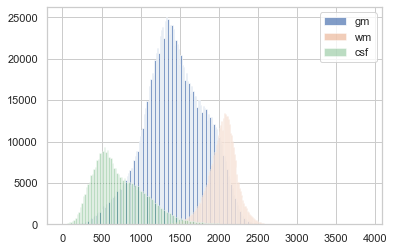

In [327]:
#Example of histogram of t1 voxel intensity by tissue type

t1 = image.load_img(glob.glob(path + '/wsub-*_T1.nii')).get_fdata().reshape(scan_shape)

gm_h = np.where(grey_matter > 0.25, t1, 0).ravel()
wm_h = np.where(white_matter > 0.5, t1, 0).ravel()
csf_h = np.where(csf > 0.5, t1, 0).ravel()


pyplot.hist(gm_h[gm_h>0], 200, alpha=0.7, label='gm')
pyplot.hist(wm_h[wm_h>0], 200, alpha=0.4, label='wm')
pyplot.hist(csf_h[csf_h>0], 200, alpha=0.4, label='csf')

pyplot.legend(loc='upper right')
pyplot.show()


In [ ]:
# Plotting electric field medians for M1 and Th
import seaborn as sns, matplotlib.pyplot as plt, operator as op

emag_results_toplot = {'M1': all_m1_emag_medians,'Thalamus': all_th_emag_medians}

sorted_keys, sorted_vals = zip(*sorted(emag_results_toplot.items(), key=op.itemgetter(1)))

sns.set(context='notebook', style='whitegrid')
sns.utils.axlabel(xlabel="ROI", ylabel="E-mag medians", fontsize=16)

sns.boxplot(data=sorted_vals, width=.18)
sns.swarmplot(data=sorted_vals, size=3, edgecolor="black", linewidth=.9)

# category labels
plt.xticks(plt.xticks()[0], sorted_keys)

plt.show()